## Advanced ML: Домашнее задание 1

1. Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).

In [730]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal
from datetime import datetime, timedelta

In [731]:
df = pd.read_csv('owid-covid-data.csv', delimiter=',', date_parser='date')

In [732]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN


In [733]:
start_date = '2020-03-03'
days = 50
FIG_SIZE = (7, 3)

In [734]:
df['date'] = pd.to_datetime(df['date'])
df = df[(df.location == 'Russia') & (df.date >= start_date)]
df = df.replace({'new_cases' : {0.0 : 1.0}})
df.reset_index(drop=True, inplace=True)
df['days'] = (df.date - datetime.strptime(start_date, "%Y-%m-%d")).dt.days

start_date_ = datetime.strptime(start_date, "%Y-%m-%d")
end_date = start_date_ + timedelta(days=days)
end_date = end_date.strftime("%Y-%m-%d")

train = df[df.date < end_date]
test = df[df.date >= end_date]
test.reset_index(drop=True, inplace=True)

print("Train is ", train.shape, ", test is", test.shape)

Train is  (50, 68) , test is (1048, 68)


2. Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.

In [737]:
def plot_variable(target):
    plt.figure(figsize=FIG_SIZE)
    plt.plot(train.date, train[target], label='train')
    plt.plot(test.date, test[target], label='test')
    plt.title(target)
    plt.legend()
    plt.show()

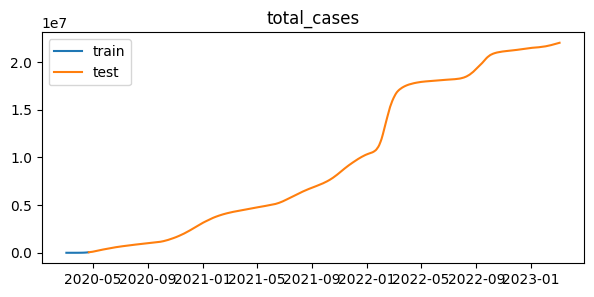

In [738]:
plot_variable('total_cases')

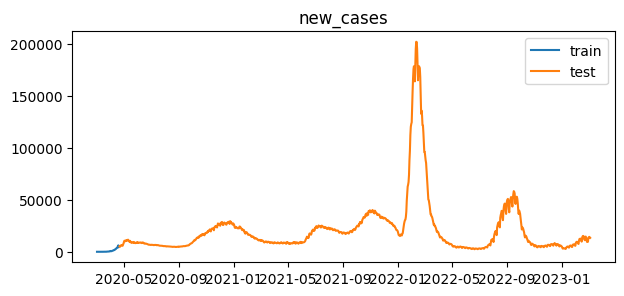

In [739]:
plot_variable('new_cases')

a) Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.

In [787]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr_model = LinearRegression()

x_train = train['days'].values.reshape(-1, 1)
x_test = test['days'].values.reshape(-1, 1)

y_train = train["total_cases"].values.reshape(-1, 1)
y_test = test["total_cases"].values.reshape(-1, 1)

lr_model.fit(x_train, np.log(y_train))
lr_pred = lr_model.predict(x_test)

In [788]:
lr_model.coef_

array([[0.19829091]])

In [789]:
train_preds = np.exp(lr_model.predict(x_train.reshape(-1, 1)))
test_preds = np.exp(lr_model.predict(x_test.reshape(-1, 1)))

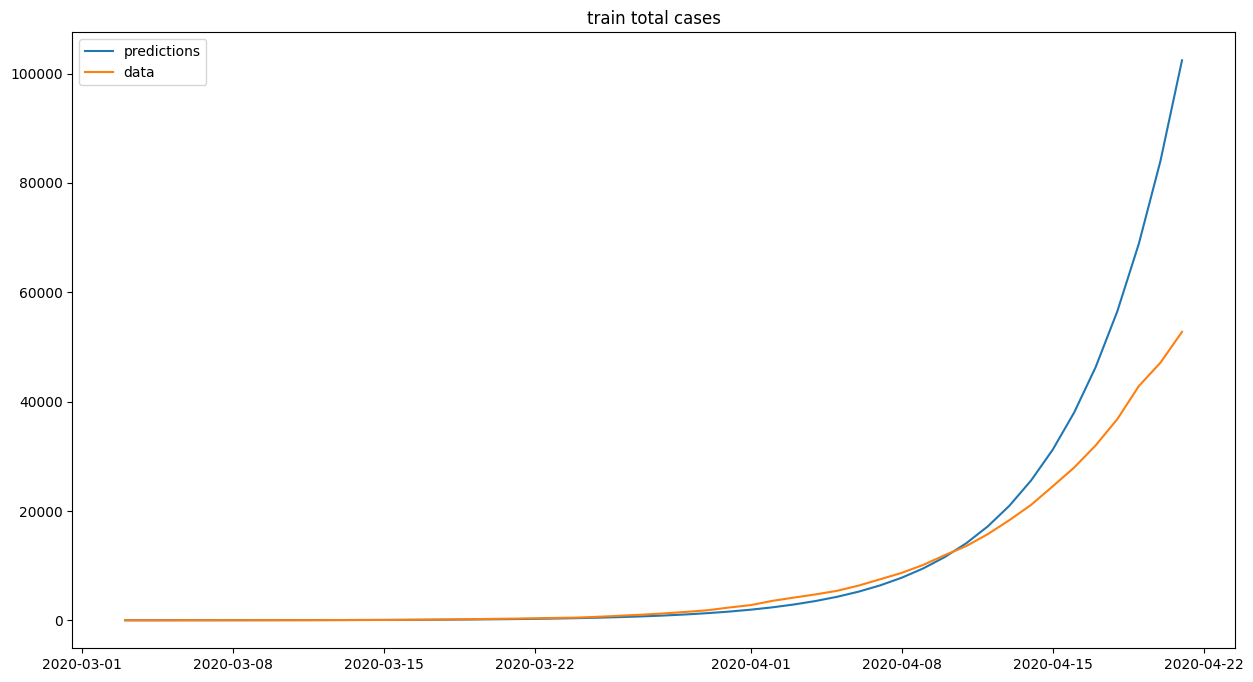

In [790]:
# plot the first 50 days

plt.figure(figsize=(15, 8))

plt.plot(train.date[:50], train_preds[:50], label='predictions')
plt.plot(train.date[:50], y_train[:50], label='data')

plt.title('train total cases')
plt.legend()
plt.show()

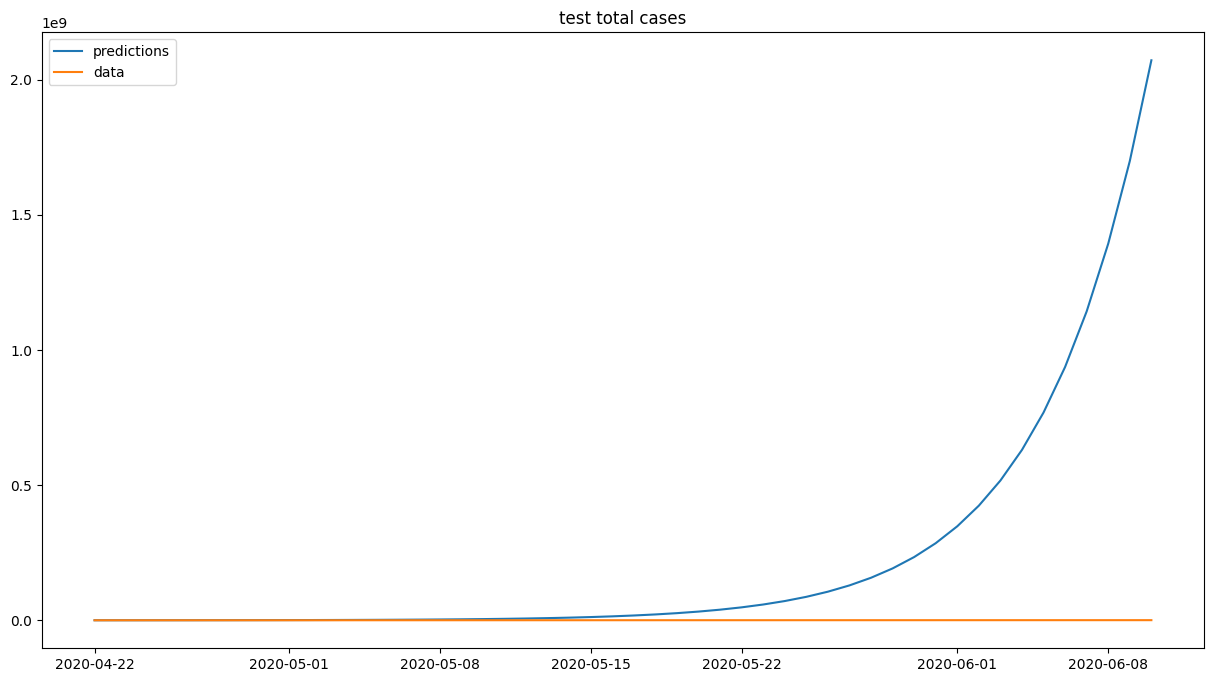

In [744]:
plt.figure(figsize=(15, 8))

plt.plot(test.date[:50], test_preds[:50], label='predictions')
plt.plot(test.date[:50], y_test[:50], label='data')
plt.title('test total cases')
plt.legend()
plt.show()

b) Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

In [777]:
def get_noise_var(y_train, train_preds):
    return (np.std(np.log(y_train) - np.log(train_preds))) ** 2

In [778]:
noise_var = get_noise_var(y_train, train_preds)
print(noise_var)

0.12183046154391228


In [779]:
def bayes_upd(mu, sigma, X, y, var):
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / var) * (np.dot(X.T, X)))                  
    mu_n = sigma_n @ (np.linalg.inv(sigma) @ mu + (1 / var) * (np.dot(X.T, y)))
    return mu_n, sigma_n


def nth_mu_sigma(X, y, var):
    mu_0 = np.vstack(np.zeros(X.shape[1]))
    sigma_0 = 3 * np.identity(X.shape[1])
    mu_n, sigma_n = bayes_upd(mu_0, sigma_0, X, y, var)
    return mu_n, sigma_n

In [780]:
X = np.c_[np.ones(train.shape[0]), train.days.values]
y = np.log(train["total_cases"].values).reshape(-1, 1)

In [781]:
mu, sigma = nth_mu_sigma(X, y, var_est)

In [782]:
print(mu.shape, mu)
print(sigma.shape, sigma)

(2, 1) [[1.80644594]
 [0.19872348]]
(2, 2) [[ 2.36253757e-02 -7.15918665e-04]
 [-7.15918665e-04  2.92809144e-05]]


c. Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

In [783]:
def sample_obj(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu.flatten(), sigma, n)
    res = np.array([w[0] + w[1] * xs for w in my_w])
    return res

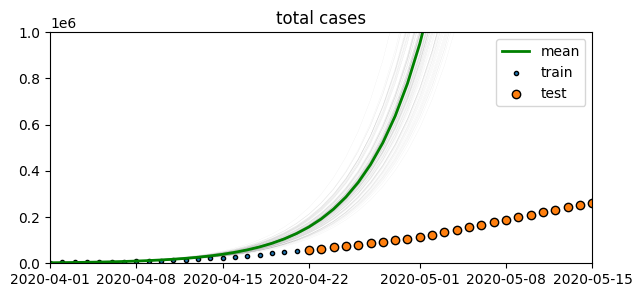

In [792]:
plt.figure(figsize=(7, 3))
    
curves = []
samples = np.random.multivariate_normal(mu.flatten(), sigma, 100)
for sample in samples:
    plt.plot(dates, np.exp(np.dot(x_mat_all, sample)), 'k', alpha=0.3, lw=0.05)
    curves.append(np.exp(np.dot(x_mat_all, sample)))
    
plt.plot(dates, np.mean(curves, axis=0), color='green', lw=2, label='mean')

plt.scatter(train.date, y_train, marker='.', edgecolors='k', label='train')
plt.scatter(test.date, y_test, marker='o', edgecolors='k', label='test')

start_point = datetime(2020, 4, 1)
end_point = datetime(2020, 5, 15)
plt.xlim(start_point, end_point)
plt.ylim(0, 10e5)
    
plt.title('total cases')
plt.legend()

In [793]:
def plot_predictions(xs, model, std, y_test, title, noise_sigma=var_est):
    plt.figure(figsize=(10, 4))
    plt.ylim((min(y_test), max(y_test)))
    
    plt.plot(xs, model, color="green", label="exp model")
    plt.plot(xs, y_test, label="Correct answer")
    plt.xlabel('days')
    plt.ylabel('total_cases')
    plt.legend()
    plt.title(title)
    plt.show()

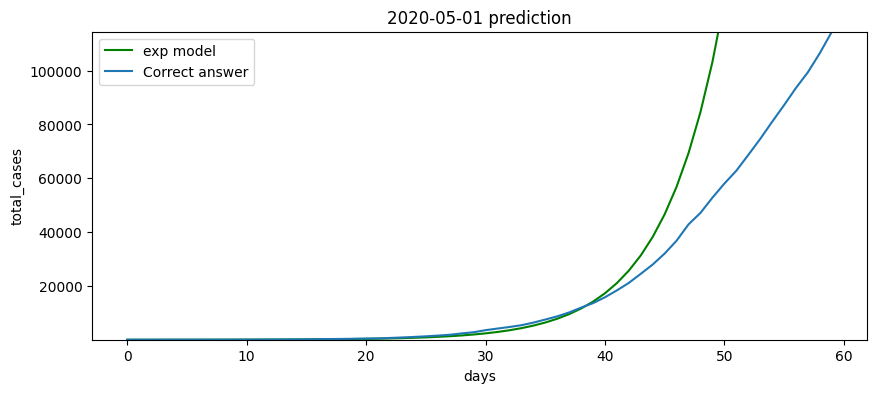

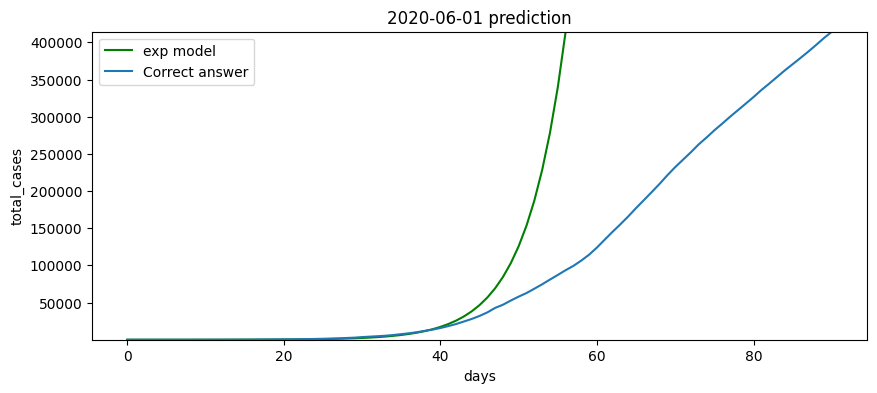

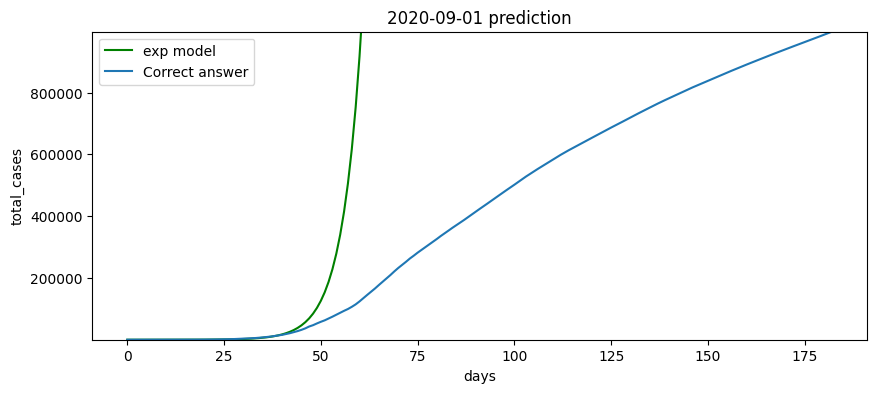

In [794]:
SAMPLES = 1000
for date in ['2020-05-01', '2020-06-01', '2020-09-01']:
    X_test = df.loc[df.date <= date, 'days'].values
    y_test = df.loc[df.date <= date, "total_cases"].values
    pred = sample_obj(mu, sigma, xs=X_test, n=SAMPLES)
    std = (np.exp(np.mean(pred, axis=0) - np.std(pred, axis=0)), np.exp(np.mean(pred, axis=0) + np.std(pred, axis=0)))
    model = np.exp(mu[0] + mu[1] * X_test)
    plot_predictions(X_test, model, std, y_test, f'{date} prediction')

In [846]:
x_all = np.concatenate((x_train, x_test))
x_mat_all = np.stack([np.ones(x_all.shape), x_all], axis=-1)

In [847]:
dates = pd.concat([train.date, test.date])

In [848]:
start_date = datetime(2020, 3, 3)

days_may = (datetime(2020, 5, 1) - start_date).days
days_june = (datetime(2020, 6, 1) - start_date).days
day_september = (datetime(2020, 9, 1) - start_date).days

sample_exponents = []
examples = np.random.multivariate_normal(mu.flatten(), sigma, 50)
for w in examples:
    sample_exponents.append(np.exp(w[0] + w[1] * x_all))
sample_exponents = np.array(sample_exponents)

print("Предсказание к  1  мая: ", int(sample_exponents.mean(axis=0)[days_may][0]))
print("Предсказание к  1  июня: ", int(sample_exponents.mean(axis=0)[days_june][0]))
print("Предсказание к  1  сентября: ", int(sample_exponents.mean(axis=0)[day_september][0]))

Предсказание к  1  мая:  726981
Предсказание к  1  июня:  355374767
Предсказание к  1  сентября:  41680688639122296


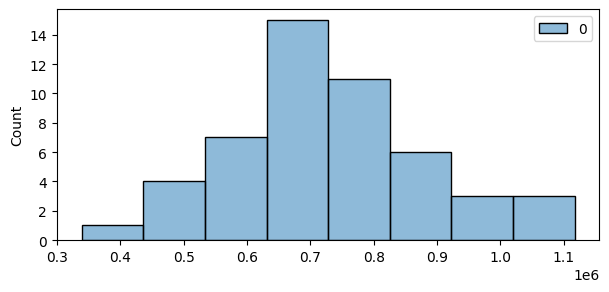

In [849]:
plt.figure(figsize=(7, 3))
sns.histplot(sample_exponents[:, days_may])
ax.set_title("Предсказательное распределение к 1 мая")
plt.show()

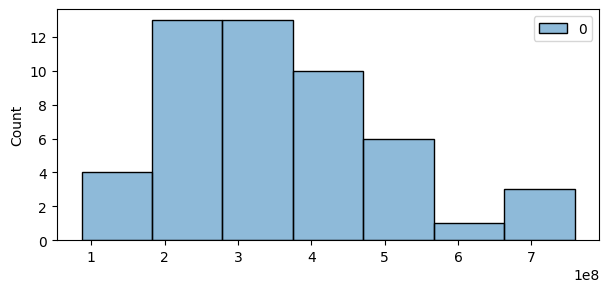

In [850]:
plt.figure(figsize=(7, 3))
sns.histplot(sample_exponents[:, days_june])
ax.set_title("Предсказательное распределение к 1 июня")
plt.show()

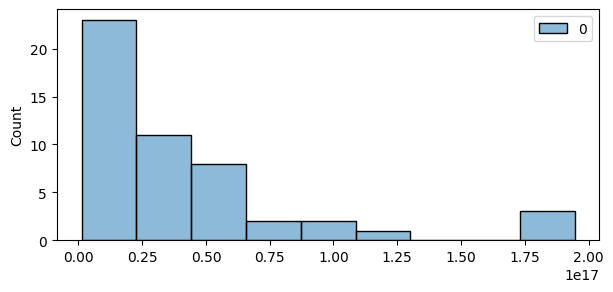

In [851]:
plt.figure(figsize=(7, 3))
sns.histplot(sample_exponents[:, day_september])
ax.set_title("Предсказательное распределение к 1 сентября")
plt.show()

3. Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана:
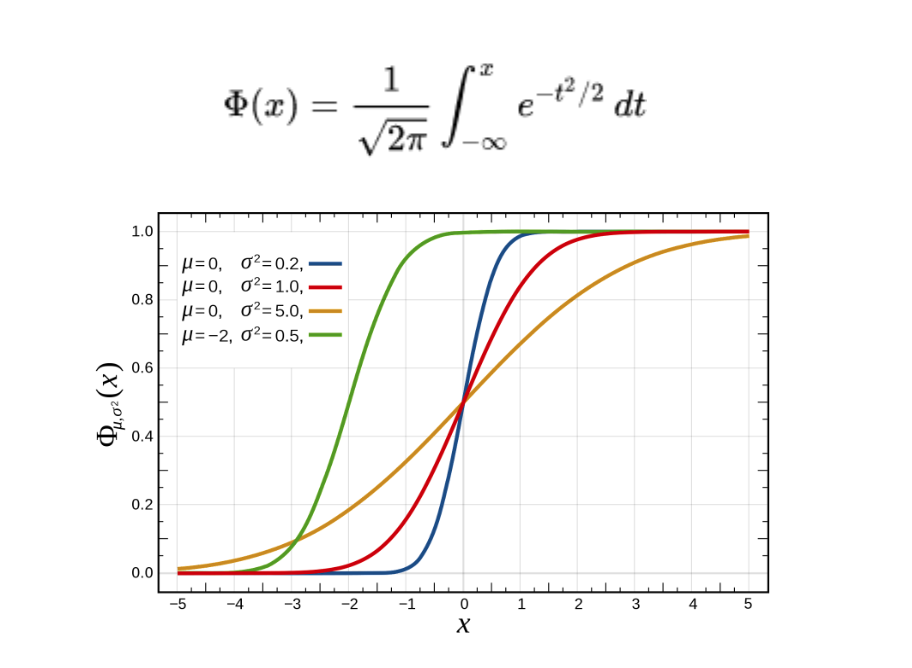


Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t.

a. Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.

Для переменной **new_cases** обучим линейную регрессию с квадратичным признаком.

**Total_cases** получим путем суммирования **new_cases**


In [818]:
y_new_train, y_new_test = train.new_cases.values, test.new_cases.values

b. Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.

In [819]:
x_new_train = np.concatenate([x_train, x_train ** 2], axis=-1)
lr_new = LinearRegression()
lr_new.fit(x_new_train, np.log(y_new_train))

LinearRegression()

In [820]:
lr_new.coef_

array([ 0.27562283, -0.00182979])

In [821]:
y_new_train_preds = np.exp(lr_new.predict(x_new_train))

In [822]:
var_new = get_noise_var(y_new_train, y_new_train_preds)

In [823]:
print(var_new)

0.2392868412700556


In [843]:
X_new = np.c_[np.ones(x_train.shape[0]), x_train, x_train**2]
mu_new, sigma_new = nth_mu_sigma(X_new, np.log(y_new_train).reshape(-1, 1), var_new)

In [844]:
print(mu_new)
print(sigma_new)

[[-0.3911065 ]
 [ 0.27517107]
 [-0.00182211]]
[[ 3.92772356e-02 -3.17327812e-03  5.34213462e-05]
 [-3.17327812e-03  3.51128647e-04 -6.70910521e-06]
 [ 5.34213462e-05 -6.70910521e-06  1.37126174e-07]]


c. Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

In [826]:
x_new_all = np.concatenate([np.ones(x_all.shape), x_all, x_all ** 2], axis=-1)

In [827]:
print(x_new_all.shape)

(1098, 3)


In [828]:
def total_cases_predictions(mu, sigma, n=25):
    samples = np.random.multivariate_normal(mu.flatten(), sigma, n)
    preds_new_cases = np.exp(np.dot(x_new_all, samples.T))
    preds_tot_cases = preds_new_cases.cumsum(axis=0)
    return preds_tot_cases.T

/tmp/ipykernel_261514/749640397.py:15: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(train.date, train["total_cases"].values, marker='+', edgecolors='k', label='train')


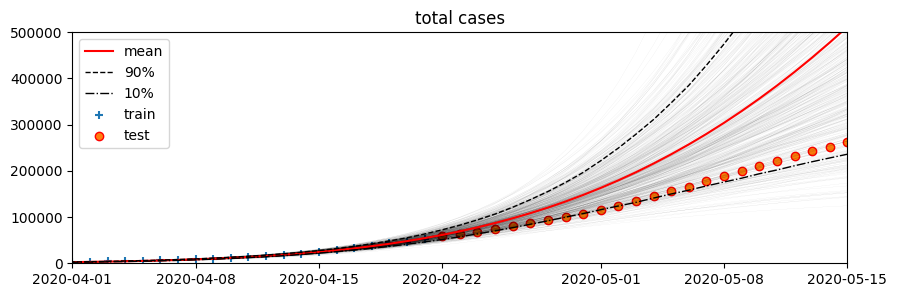

In [831]:
plt.figure(figsize=(10, 3))

SAMPLES = 500
curves = []
samples = total_cases_predictions(mu_new, sigma_new, SAMPLES)

for sample in samples:
    plt.plot(dates, sample, 'k', alpha=0.3, lw=0.05)
    curves.append(sample)
    
plt.plot(dates, np.mean(curves, axis=0), color='red', label='mean')
plt.plot(dates, np.percentile(curves, 90, axis=0), ls='--', c='k', lw=1, label='90%')
plt.plot(dates, np.percentile(curves, 10, axis=0), ls='-.', c='k', lw=1, label='10%')

plt.scatter(train.date, train["total_cases"].values, marker='+', edgecolors='k', label='train')
plt.scatter(test.date, test["total_cases"].values, marker='o', edgecolors='r', label='test')

plt.xlim(start_point, end_point)
plt.ylim(0, 500000)
    
plt.title('total cases')
plt.legend()

**Реальная статистика заболеваемости близка к 10 перцентилю**

In [833]:
pred =  samples[:, -1]
print(f"90-percentile = {int(np.percentile(pred, 90))}")
print(f"10-percentile = {int(np.percentile(pred, 10))}")

90-percentile = 8420662
10-percentile = 343643


Вывод: результаты значительно лучше, чем в случае с экспонентой, однако так же далеки от правды

4. Бонус: проведите такой же анализ для других стран (здесь придётся руками подобрать дни начала моделирования — коронавирус приходил в разные страны в разное время). Насколько разные параметры получаются? Можно ли разделить страны на кластеры (хотя бы чисто визуально) в зависимости от этих параметров?

In [834]:
days = 50
needed_cols = ['date', 'total_cases', 'new_cases']
for_test = 100

In [835]:
df = pd.read_csv('owid-covid-data.csv', delimiter=',', date_parser='date')

In [836]:
start_days = { 'Russia': '2020-03-03',
               'United Kingdom':'2020-02-15',
               'Germany': '2020-02-13',
               'France':'2020-01-24',
               'Spain': '2020-02-01',
               'Italy': '2020-02-07',
               'Japan': '2020-02-26',
               'South Korea': '2020-01-26',
               'United States': '2020-02-20',
               'Iran': '2020-02-19'
                } 
needed_cols = ['date', 'total_cases', 'new_cases']
country_params = {}

In [837]:
X_all_ = np.stack([np.ones(for_test+ days), np.arange(1, for_test + days + 1), 
                    np.arange(1, for_test + days + 1) ** 2], axis=-1)


def country_fig(location, df, mu, sigma):
    plt.figure(figsize=(10, 3))
    
    samples = np.random.multivariate_normal(mu.flatten(), sigma, 500)
    all_dates = df.date.values[:days + for_test]
    curves_tot = []
    
    for sample in samples:
        preds_new = np.exp(np.dot(X_all_, sample))
        preds_tot = preds_new.cumsum()
        curves_tot.append(preds_tot)
        plt.plot(all_dates, preds_tot, 'k', alpha=0.3, lw=0.05)
    plt.plot(all_dates, np.mean(curves_tot, axis=0), c='green', lw=2, label='mean')
    plt.plot(all_dates, np.percentile(curves_tot, 90, axis=0), ls='--', c='k', lw=1, label='90%')
    
    plt.plot(data.date[:days + for_test], np.percentile(curves_tot, 10, axis=0), ls='-.', c='k', lw=1, label='10%')
    plt.scatter(df.date[:days], df.total_cases[:days], marker='.', edgecolors='k', label='train')
    plt.scatter(df.date[days:days + for_test], df.total_cases[days: days+ for_test], marker='.', edgecolors='k', label='test')
    
    plt.ylim(0, data[:days + for_test].total_cases.max())

    plt.title(f"Total cases in {location}")
    plt.legend()
    plt.show()

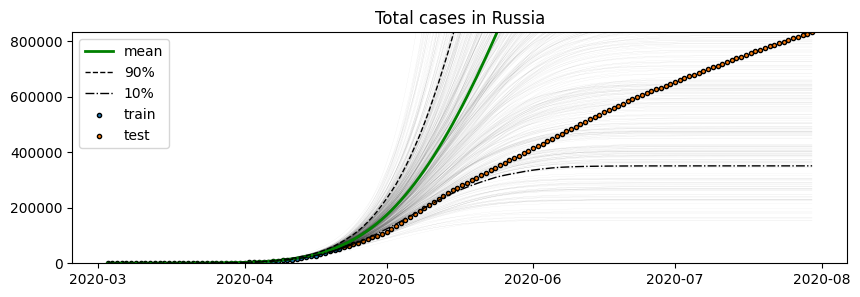

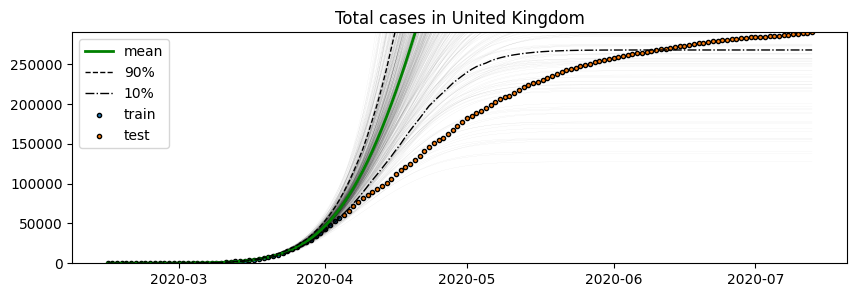

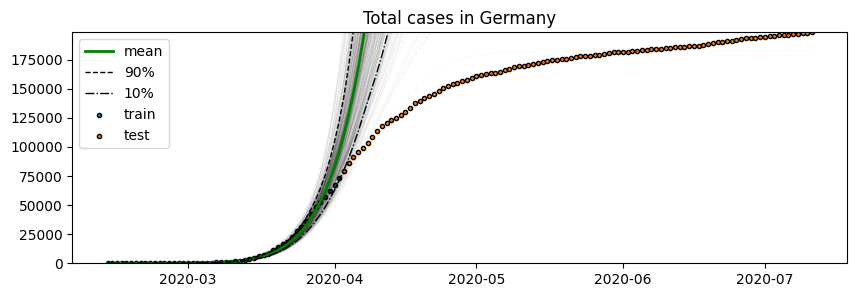

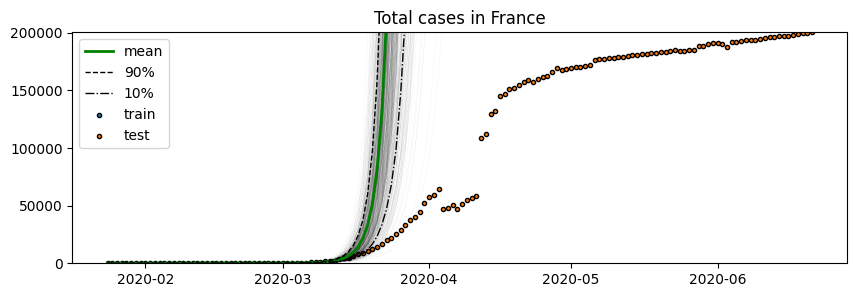

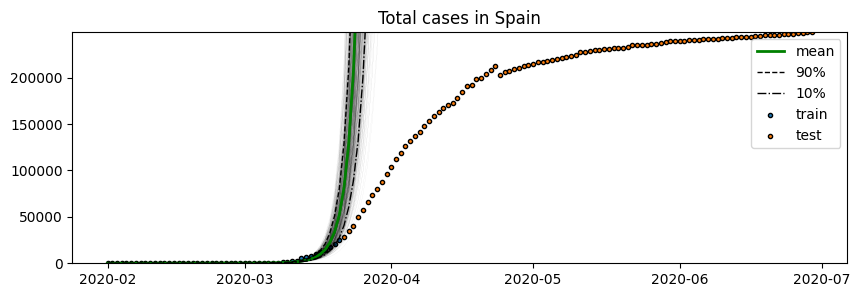

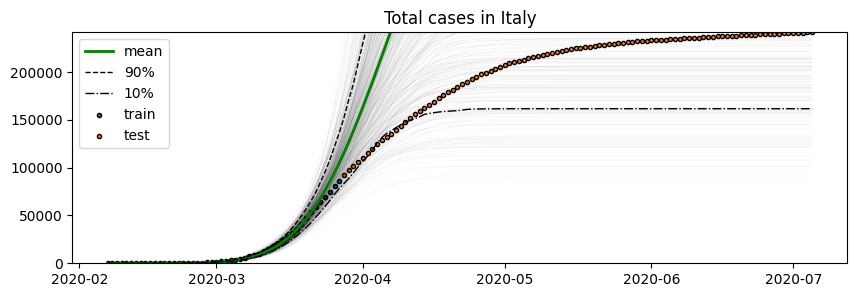

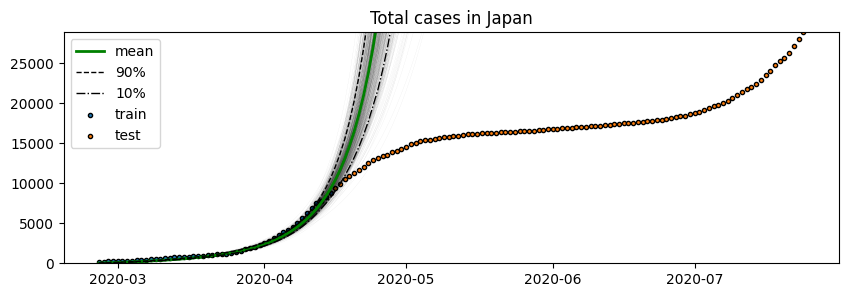

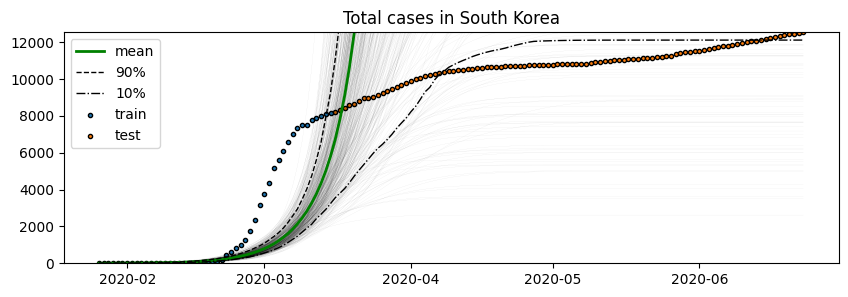

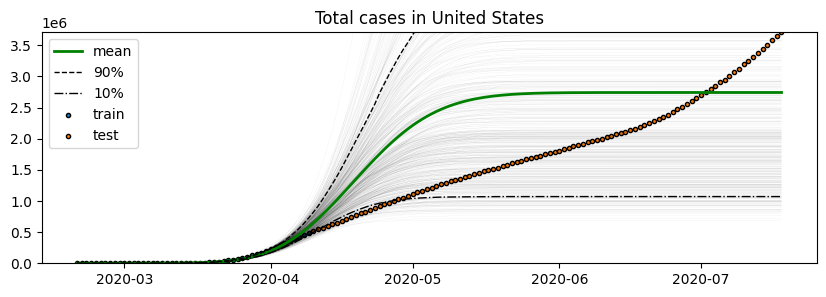

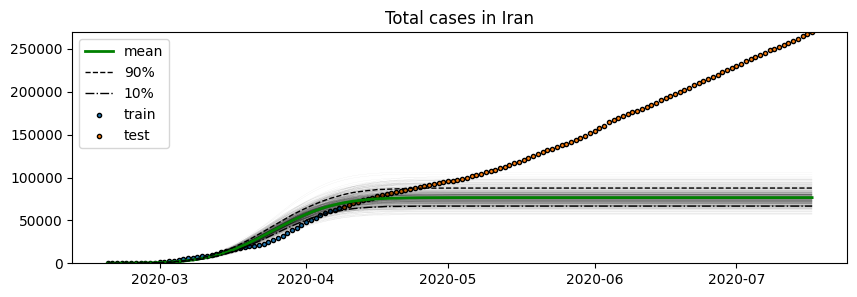

In [838]:
for location, start_date in start_days.items():
    df['date'] = pd.to_datetime(df['date'])
    data = df.loc[(df.location == location) & (df.date >= start_date), cols]
    data = data.replace({'new_cases' : {0.0 : 1.0}})
    data.reset_index(drop=True, inplace=True)
    data['days'] = (data.date - datetime.strptime(start_date, "%Y-%m-%d")).dt.days
    data = data.replace({'new_cases' : {0.0 : 1.0}})
    
    start_date_ = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = start_date_ + timedelta(days=days)
    end_date = end_date.strftime("%Y-%m-%d")

    train = data[data.date < end_date]
    test = data[data.date >= end_date]
    test.reset_index(drop=True, inplace=True)
    
    x_train = train['days'].values.reshape(-1, 1)
    x_test = test['days'].values.reshape(-1, 1)

    y_train = train["new_cases"].values.reshape(-1, 1)
    y_test = test["new_cases"].values.reshape(-1, 1)
    
    model = LinearRegression()
    train_input = np.concatenate([x_train, x_train ** 2], axis=-1)
    model.fit(train_input, np.log(y_train))
    
    train_preds = np.exp(model.predict(train_input))
    var_est = (np.std(np.log(y_train) - np.log(train_preds))) ** 2

    X_all = np.concatenate([np.ones(x_train.shape), x_train, x_train ** 2], axis=-1)
    mu_, sigma_ = nth_mu_sigma(X_all, np.log(y_train), var_est)

    country_params[location] = mu_.flatten()
    country_fig(location, data, mu_, sigma_)

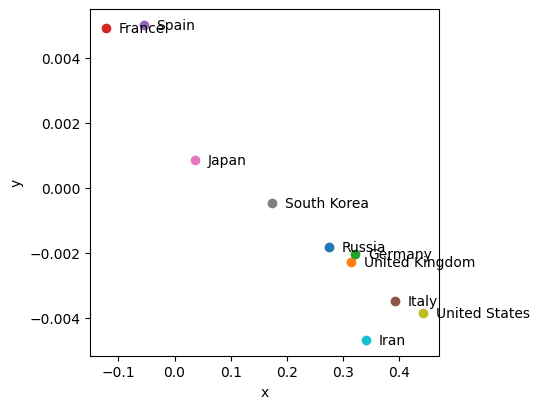

In [855]:
plt.figure(figsize=(4.5, 4.5))
ax = plt.gca()

for country, (x, y, z) in country_params.items():
    plt.scatter(y, z, marker='o')
    ax.annotate(text=country, xy=(y, z), xytext=(9, -3), textcoords='offset points')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
plt.show()

## Part 5:

Экспоненциальная модель абсолютно нереалистичная.

Сигмоидальная модель неплохо предсказывает только на первые несколько дней прогнозов.

**Итог**: ни сигмоидальная, ни экспоненциальная модели данных не отображают реальное распространение Covid-19.

Также мы уже знаем, что были несколько волн короновируса, когда заболеваемость снижалась, что сигмоида тоже не может отобразить.

Решение о вводе карантина, на мой взгляд, должно принимать в счет не только динамику заболеваемости, а также другие факторы, такие как: заполненость больниц, состояние экономики, общественные настроения людей и др.